In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install seaborn

In [ ]:
pip install imbalanced-learn

In [ ]:
import os
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

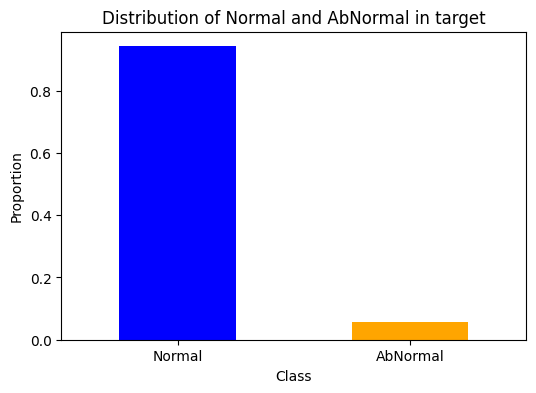

<ipython-input-4-b27977dee80c>:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_x['WorkMode_High'] = train_x['WorkMode Collect Result_Fill2'] > 2.0
<ipython-input-4-b27977dee80c>:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_x['WorkMode_High'] = test_x['WorkMode Collect Result_Fill2'] > 2.0
<ipython-input-4-b27977dee80c>:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

Voting Classifier F1 Score: 0.9680

Classification Report:
              precision    recall  f1-score   support

    AbNormal       0.97      0.97      0.97     11447
      Normal       0.97      0.97      0.97     11447

    accuracy                           0.97     22894
   macro avg       0.97      0.97      0.97     22894
weighted avg       0.97      0.97      0.97     22894



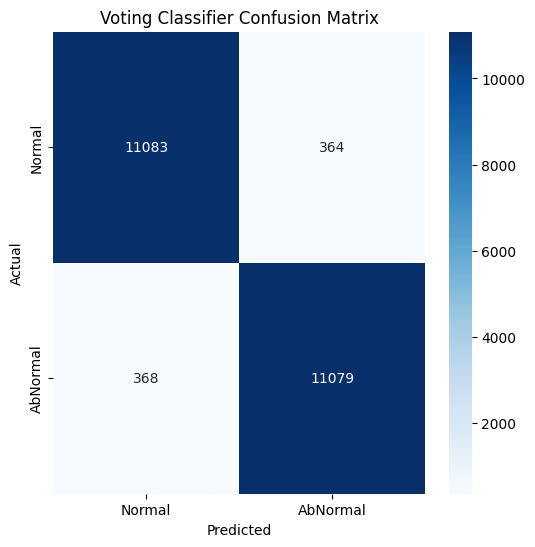

In [ ]:
'''
[1. 데이터 로드]
'''
# 데이터가 저장된 디렉토리와 랜덤 시드 값 설정
ROOT_DIR = "/content/drive/MyDrive/LG_AIMERS/data"
RANDOM_STATE = 110

# 학습 데이터와 테스트 데이터 불러오기
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))


'''
[2. 목표 변수 분포 시각화]
타켓 변수의 분포를 시각화하여 데이터의 불균형을 확인
'''
# 'Normal'과 'AbNormal' 클래스 간의 비율을 확인
target_counts = train_data['target'].value_counts(normalize=True)
plt.figure(figsize=(6, 4))
target_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Normal and AbNormal in target')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

'''
[3. 공통 결측치 열 제거]
: 모델 학습에 방해가 될 수 있는 결측치를 처리하는 과정
'''
# 학습 데이터와 테스트 데이터의 결측치가 있는 열을 찾기
nan_columns_train = train_data.columns[train_data.isna().any()].tolist()
nan_columns_test = test_data.columns[test_data.isna().any()].tolist()

# 학습 데이터와 테스트 데이터에서 공통으로 결측치가 있는 열을 찾기
common_nan_columns = list(set(nan_columns_train) & set(nan_columns_test))

# 공통 결측치 열을 제거
train_data = train_data.drop(columns=common_nan_columns)
test_data = test_data.drop(columns=common_nan_columns)

'''
[4. 특징과 목표 변수 분리]
: 학습 데이터에서 특징과 목표 변수를 분리하고, 테스트 데이터에서는 'set id'와
'target' 열을 제거하여 모델 예측에 필요한 특징만 남긴다.
'''
# 학습 데이터의 특징(feature)와 목표 변수(target) 분리
train_x = train_data.drop(columns=["target"])
train_y = train_data["target"]

# 테스트 데이터에서 필요 없는 열 제거
test_x = test_data.drop(columns=["Set ID", "target"], errors='ignore')

# 테스트 데이터의 'set ID' 열 저장
test_set_id = test_data['Set ID']

'''
[5. 수치형 및 범주형 열 분리]
: 데이터의 수치형 열과 범주형 열을 분리하여 각각 다른 방식으로 전처리한다.
'''
# 수치형(numeric)열과 범주형(categorical) 열 분리
numeric_cols = train_x.select_dtypes(include=['number']).columns
categorical_cols = train_x.select_dtypes(include=['object']).columns

'''
[6. 결측치 채우기]
: 수치형 열의 결측치는 중앙값(median)으로,
범주형 열의 결측치는 최빈값(most frequent)으로 채운다.
'''
numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_x[numeric_cols] = numeric_imputer.fit_transform(train_x[numeric_cols])
test_x[numeric_cols] = numeric_imputer.transform(test_x[numeric_cols])
train_x[categorical_cols] = categorical_imputer.fit_transform(train_x[categorical_cols])
test_x[categorical_cols] = categorical_imputer.transform(test_x[categorical_cols])

'''
[7. 범주형 변수 인코딩]
: 범주형 열은 레이블 인코딩(label encoding)을 사용하여 숫자로 변환한다.
'''
# 범주형 변수들을 Label Encoding 방식으로 숫자로 변환
def preprocess_data(df, categorical_cols):
    label_encoders = {}
    for column in categorical_cols:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le
    return df

train_x = preprocess_data(train_x, categorical_cols)
test_x = preprocess_data(test_x, categorical_cols)

'''
[8. 추가 특징 엔지니어링]
: 새로운 특징을 생성하여 데이터의 정보량을 증가시킵니다.
예를 들어, WorkMode_High는 특정 열의 값이 2보다 큰지 여부에 따라
이진 특징을 생성하고, Model_Equipment_Combined는 두 열의 문자열 결합을 통해
새로운 범주형 특징을 만듭니다.
'''
# 'WorkMode_High'라는 새로운 이진 특징 생성
train_x['WorkMode_High'] = train_x['WorkMode Collect Result_Fill2'] > 2.0
test_x['WorkMode_High'] = test_x['WorkMode Collect Result_Fill2'] > 2.0

train_x['WorkMode_High'] = train_x['WorkMode_High'].astype(int)
test_x['WorkMode_High'] = test_x['WorkMode_High'].astype(int)

# 'Model_Equipment_Combined'라는 새로운 결합 특징 생성
train_x['Model_Equipment_Combined'] = train_x['Model.Suffix_Dam'].astype(str) + "_" + train_x['Equipment_Dam'].astype(str)
test_x['Model_Equipment_Combined'] = test_x['Model.Suffix_Dam'].astype(str) + "_" + test_x['Equipment_Dam'].astype(str)

# 'WorkMode Collect Result_Fill2'의 값에 따라 'WorkMode_Binned'라는 범주형 특징 생성
train_x['WorkMode_Binned'] = pd.cut(train_x['WorkMode Collect Result_Fill2'], bins=[-np.inf, 1.0, 2.0, np.inf], labels=['Low', 'Medium', 'High'])
test_x['WorkMode_Binned'] = pd.cut(test_x['WorkMode Collect Result_Fill2'], bins=[-np.inf, 1.0, 2.0, np.inf], labels=['Low', 'Medium', 'High'])

'''
[9. 추가된 특징 인코딩 및 스케일링]
: 추가된 특징들을 Label Encoding 및 One-Hot Encoding을 통해 인코딩하고,
StandardScaler를 사용해 모든 특징을 표준화합니다.
'''
# 추가된 결합 특징들을 Label Encoding 방식으로 인코딩
combined_factor_le = LabelEncoder()
train_x['Combined_Factor'] = (
    train_x['Equipment_Dam'].astype(str) + '_' +
    train_x['Model.Suffix_Dam'].astype(str) + '_' +
    train_x['WorkMode_High'].astype(str)
)

test_x['Combined_Factor'] = (
    test_x['Equipment_Dam'].astype(str) + '_' +
    test_x['Model.Suffix_Dam'].astype(str) + '_' +
    test_x['WorkMode_High'].astype(str)
)

train_x['Combined_Factor'] = combined_factor_le.fit_transform(train_x['Combined_Factor'])
test_x['Combined_Factor'] = combined_factor_le.transform(test_x['Combined_Factor'])

# 원-핫 인코딩을 사용하여 새로운 범주형 특징들을 인코딩
train_x = pd.concat([train_x, pd.get_dummies(train_x[['Combined_Factor', 'Model_Equipment_Combined', 'WorkMode_Binned']], drop_first=True)], axis=1)
test_x = pd.concat([test_x, pd.get_dummies(test_x[['Combined_Factor', 'Model_Equipment_Combined', 'WorkMode_Binned']], drop_first=True)], axis=1)

# 필요하지 않은 원래의 특징 열 제거
train_x = train_x.drop(columns=['Combined_Factor', 'Model_Equipment_Combined', 'WorkMode_Binned'])
test_x = test_x.drop(columns=['Combined_Factor', 'Model_Equipment_Combined', 'WorkMode_Binned'])

# 모든 특징을 표준화하여 평균을 0, 표준편차를 1로 만듦
scaler = StandardScaler()
train_x = pd.DataFrame(scaler.fit_transform(train_x), columns=train_x.columns)
test_x = pd.DataFrame(scaler.transform(test_x), columns=test_x.columns)

'''
[10. 데이터셋 균형 조정]
: SMOTE(Synthetic Minority Over-sampling Technique)를 사용하여
불균형한 데이터셋을 조정하여 모델 학습 성능을 향상시킵니다.
'''
smote = SMOTE(random_state=RANDOM_STATE)
train_x, train_y = smote.fit_resample(train_x, train_y)

'''
[11. 데이터 분할]
: 학습 데이터를 학습 데이터 70%와 검증 데이터 30%로 분할하여 모델의 성능을 평가합니다.
'''
X_train, X_val, y_train, y_val = train_test_split(
    train_x, train_y, test_size=0.3, stratify=train_y, random_state=RANDOM_STATE
)

'''
[12. 모델 정의 및 학습]
: 랜덤 포레스트, 그래디언트 부스팅, KNN 모델을 사용하여
앙상블 모델(VotingClassifier)을 정의하고 학습합니다.
soft 보팅 방식을 사용하여 각 모델의 확률을 기반으로 최종 예측을 결정합니다.
'''
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Random Forest, Gradient Boosting, KNN 모델 정의
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
gb_model = GradientBoostingClassifier(random_state=RANDOM_STATE)
knn_model = KNeighborsClassifier()

# Voting Classifier 정의 (소프트 보팅 방식)
voting_clf = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('gb', gb_model),
    ('knn', knn_model)
], voting='soft')  # 'soft' 보팅을 사용해 모델의 확률을 기반으로 예측

# 앙상블 모델 학습
voting_clf.fit(X_train, y_train)

'''
[13. 모델 평가]
: 검증 데이터를 통해 모델 성능을 평가하고,
F1 스코어 및 분류 리포트(Classification Report)와
혼동 행렬(Confusion Matrix)을 시각화하여 평가 결과를 분석합니다.
'''
# 검증 데이터로 예측 수행
val_predictions = voting_clf.predict(X_val)

# F1 Score 계산
f1 = f1_score(y_val, val_predictions, pos_label="AbNormal")
print(f"Voting Classifier F1 Score: {f1:.4f}")

# Classification Report 출력
print("\nClassification Report:")
print(classification_report(y_val, val_predictions))

# Confusion Matrix 시각화
cm = confusion_matrix(y_val, val_predictions, labels=["Normal", "AbNormal"])
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "AbNormal"], yticklabels=["Normal", "AbNormal"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Voting Classifier Confusion Matrix")
plt.show()


In [ ]:
'''
[14. 테스트 데이터 예측 및 결과 저장]
: 학습된 모델을 사용하여 테스트 데이터를 예측하고,
'Set ID', 'Prediction', 'target' 열을 포함하여 결과를 저장합니다.
'''
# 테스트 데이터 예측 및 결과 저장
test_predictions = voting_clf.predict(test_x)

# 'Set ID' 열을 포함하여 결과를 저장
output = pd.DataFrame({'Set ID': test_set_id, 'Prediction': test_predictions})

# 'target' 열 추가
output["target"] = test_predictions

# 제출 파일 저장 (Set ID가 포함된 상태로 저장)
output.to_csv("submission.csv", index=False)